In [44]:
!pip install --upgrade imbalanced-learn
import warnings
warnings.simplefilter('ignore')
import math
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import timedelta
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_curve, roc_auc_score,confusion_matrix, classification_report
from xgboost import XGBClassifier


In [45]:
loan_applications_df = pd.read_csv('loan_applications.csv')
transactions_df = pd.read_csv('transactions.csv')
display(loan_applications_df.head())
transactions_df.head()

,application_id,customer_id,application_date,loan_type,loan_amount_requested,loan_tenure_months,interest_rate_offered,purpose_of_loan,employment_status,monthly_income,...,existing_emis_monthly,debt_to_income_ratio,property_ownership_status,residential_address,applicant_age,gender,number_of_dependents,loan_status,fraud_flag,fraud_type
0,c8bf0bea-70e6-4870-9125-41b8210c527f,CUST109427,2023-04-09,Business Loan,604000.0,12,11.66,Medical Emergency,Retired,34700.0,...,1100.0,3.17,Rented,"94/31, Sehgal Zila, Vadodara-380521, Anantapur...",28,Female,3,Approved,0,NaN
1,91224cec-3544-4bc7-ac15-a9792da54c02,CUST106146,2023-09-23,Car Loan,100000.0,240,13.62,Education,Unemployed,51600.0,...,0.0,0.00,Owned,"H.No. 00, Sheth Chowk, Ichalkaranji 006728, Im...",44,Other,3,Approved,0,NaN
2,4efcd02d-4a03-4ab7-9bd1-0ff430493d0c,CUST100674,2023-05-22,Education Loan,431000.0,60,11.40,Medical Emergency,Self-Employed,14800.0,...,4600.0,31.08,Rented,"H.No. 81, Dutta Path, Kozhikode-340301, Tadepa...",56,Other,4,Approved,0,NaN
3,a61337d4-ba04-4a68-b492-2cb8266e6ed7,CUST106466,2024-07-09,Car Loan,324000.0,120,10.36,Debt Consolidation,Self-Employed,28800.0,...,4000.0,13.89,Rented,"H.No. 022, Rege Road, Tiruvottiyur-927857, Aur...",27,Other,4,Declined,0,NaN
4,a8d1639e-170b-41b2-826a-55c7dae38d16,CUST112319,2023-11-20,Personal Loan,100000.0,36,14.14,Business Expansion,Salaried,43900.0,...,1100.0,2.51,Rented,"85/24, Bali Zila, Sambalpur 922071, Tumkur, Ke...",50,Other,0,Declined,0,NaN


,transaction_id,customer_id,transaction_date,transaction_type,transaction_amount,merchant_category,merchant_name,transaction_location,account_balance_after_transaction,is_international_transaction,device_used,ip_address,transaction_status,transaction_source_destination,transaction_notes,fraud_flag
0,2d7ddfd4-1112-4354-a2dd-fad94b45a850,CUST102188,2022-01-04 11:27:00,Bill Payment,2100.0,Dining,"Rattan, Khanna and Magar","Srikakulam, Himachal Pradesh",8211.0,0,Web,31.102.21.141,Success,BCHG80012468703731,Payment for Dining,0
1,ba998721-a612-4e0a-8354-46d001e9c39c,CUST107144,2022-01-03 23:52:00,UPI,1400.0,Travel,Chauhan LLC,"Giridih, Manipur",12858.0,0,Web,176.48.222.166,Success,CJPZ11841095072972,Payment for Travel,0
2,0b4ad8e2-40ac-49c9-b59a-c9efaaccc7a6,CUST102126,2022-01-15 06:54:00,Debit Card,1000.0,Entertainment,Halder-Sarma,"Avadi, Kerala",19268.0,0,ATM,181.62.105.161,Success,TLCG50761416960179,Payment for Entertainment,0
3,c4fce988-34c5-48db-8686-bfad0b3bc0b5,CUST109887,2022-01-08 07:57:00,Credit Card,10500.0,Utilities,"Anand, Khare and Balakrishnan","Navi Mumbai, Maharashtra",29585.0,0,ATM,121.157.246.80,Success,PRZJ55096553432036,Payment for Utilities,0
4,f9b8ca30-00e5-4322-8cff-eac0554cf2da,CUST108620,2022-01-02 10:43:00,Loan Disbursement,8100.0,Electronics,Zacharia and Sons,"Visakhapatnam, Gujarat",0.0,0,ATM,129.96.5.57,Success,NBAI29021393288369,Payment for Electronics,0


In [46]:
print("Loan Applications DataFrame Info:")
loan_applications_df.info()


Loan Applications DataFrame Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 21 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   application_id             50000 non-null  object 
 1   customer_id                50000 non-null  object 
 2   application_date           50000 non-null  object 
 3   loan_type                  50000 non-null  object 
 4   loan_amount_requested      50000 non-null  float64
 5   loan_tenure_months         50000 non-null  int64  
 6   interest_rate_offered      50000 non-null  float64
 7   purpose_of_loan            50000 non-null  object 
 8   employment_status          50000 non-null  object 
 9   monthly_income             50000 non-null  float64
 10  cibil_score                50000 non-null  int64  
 11  existing_emis_monthly      50000 non-null  float64
 12  debt_to_income_ratio       50000 non-null  float64
 13  property_own

In [47]:
print("Loan Applications DataFrame Info:")
transactions_df.info()


Loan Applications DataFrame Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 16 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   transaction_id                     50000 non-null  object 
 1   customer_id                        50000 non-null  object 
 2   transaction_date                   50000 non-null  object 
 3   transaction_type                   50000 non-null  object 
 4   transaction_amount                 50000 non-null  float64
 5   merchant_category                  50000 non-null  object 
 6   merchant_name                      50000 non-null  object 
 7   transaction_location               50000 non-null  object 
 8   account_balance_after_transaction  50000 non-null  float64
 9   is_international_transaction       50000 non-null  int64  
 10  device_used                        50000 non-null  object 
 11  ip_address          

In [48]:
# 将 fraud_flag 映射为布尔值（True/False）并设置为分类变量
loan_applications_df['fraud_flag'] = loan_applications_df['fraud_flag'].apply(lambda x: True if x == 1 else False)

# 查看结果
fraud_vals = loan_applications_df['fraud_flag'].value_counts()
fraud_dtype = loan_applications_df['fraud_flag'].dtype

print(fraud_vals, fraud_dtype)



loan_applications_df['loan_status'] = loan_applications_df['loan_status'].apply(
    lambda x: True if str(x).strip().lower() == 'declined' else False)

status_vals = loan_applications_df['loan_status'].value_counts()
status_dtype = loan_applications_df['loan_status'].dtype

print(status_vals, status_dtype)



# 将 transaction_status 转换为布尔值（Failed 为 True，其它为 False），并设为分类变量
transactions_df['transaction_status'] = transactions_df['transaction_status'].apply(
    lambda x: True if str(x).strip().lower() == 'failed' else False)

# 查看转换后的值和类型
status_vals = transactions_df['transaction_status'].value_counts()
status_dtype = transactions_df['transaction_status'].dtype

print(status_vals, status_dtype)

# 将 is_international_transaction 转换为布尔值（True/False）并设为分类变量
transactions_df['is_international_transaction'] = transactions_df['is_international_transaction'].apply(
    lambda x: True if x == 1 else False)

# 查看转换后的值和数据类型
international_vals = transactions_df['is_international_transaction'].value_counts()
dtype_info = transactions_df['is_international_transaction'].dtype
print(international_vals, dtype_info)

# 将 fraud_flag 映射为布尔值（True/False）并设置为分类变量
transactions_df['fraud_flag'] = transactions_df['fraud_flag'].apply(lambda x: True if x == 1 else False)

# 查看结果
fraud_vals = transactions_df['fraud_flag'].value_counts()
fraud_dtype = transactions_df['fraud_flag'].dtype

print(fraud_vals, fraud_dtype)

fraud_flag
False    48974
True      1026
Name: count, dtype: int64 bool
loan_status
False    41908
True      8092
Name: count, dtype: int64 bool
transaction_status
False    49745
True       255
Name: count, dtype: int64 bool
is_international_transaction
False    49478
True       522
Name: count, dtype: int64 bool
fraud_flag
False    49498
True       502
Name: count, dtype: int64 bool


In [49]:
transactions_df

,transaction_id,customer_id,transaction_date,transaction_type,transaction_amount,merchant_category,merchant_name,transaction_location,account_balance_after_transaction,is_international_transaction,device_used,ip_address,transaction_status,transaction_source_destination,transaction_notes,fraud_flag
0,2d7ddfd4-1112-4354-a2dd-fad94b45a850,CUST102188,2022-01-04 11:27:00,Bill Payment,2100.0,Dining,"Rattan, Khanna and Magar","Srikakulam, Himachal Pradesh",8211.0,False,Web,31.102.21.141,False,BCHG80012468703731,Payment for Dining,False
1,ba998721-a612-4e0a-8354-46d001e9c39c,CUST107144,2022-01-03 23:52:00,UPI,1400.0,Travel,Chauhan LLC,"Giridih, Manipur",12858.0,False,Web,176.48.222.166,False,CJPZ11841095072972,Payment for Travel,False
2,0b4ad8e2-40ac-49c9-b59a-c9efaaccc7a6,CUST102126,2022-01-15 06:54:00,Debit Card,1000.0,Entertainment,Halder-Sarma,"Avadi, Kerala",19268.0,False,ATM,181.62.105.161,False,TLCG50761416960179,Payment for Entertainment,False
3,c4fce988-34c5-48db-8686-bfad0b3bc0b5,CUST109887,2022-01-08 07:57:00,Credit Card,10500.0,Utilities,"Anand, Khare and Balakrishnan","Navi Mumbai, Maharashtra",29585.0,False,ATM,121.157.246.80,False,PRZJ55096553432036,Payment for Utilities,False
4,f9b8ca30-00e5-4322-8cff-eac0554cf2da,CUST108620,2022-01-02 10:43:00,Loan Disbursement,8100.0,Electronics,Zacharia and Sons,"Visakhapatnam, Gujarat",0.0,False,ATM,129.96.5.57,False,NBAI29021393288369,Payment for Electronics,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49995,3b270807-2e36-448c-af51-d4fa8d776541,CUST115421,2022-01-29 07:54:00,Net Banking,25300.0,Healthcare,Mahal Group,"Bhagalpur, Maharashtra",0.0,False,ATM,204.192.254.120,False,IOLU31003238734472,Payment for Healthcare,False
49996,c2c714a4-4064-4190-a2a1-01487321e9a4,CUST110943,2022-01-16 16:02:00,ATM Withdrawal,7400.0,Financial Services,Das LLC,"Lucknow, Chhattisgarh",38503.0,False,POS,11.12.241.110,False,Self,Payment for Financial Services,False
49997,25d1f375-182b-49c3-b609-15408848e5ca,CUST107349,2022-01-12 18:33:00,ATM Withdrawal,1300.0,Electronics,Jaggi LLC,"Thane, Uttar Pradesh",23742.0,False,ATM,82.197.51.173,False,Self,Payment for Electronics,False
49998,6e4a92aa-f923-43fd-96de-1835ad01d639,CUST104844,2022-01-19 11:21:00,Fund Transfer,6600.0,Groceries,Chada-Saha,"Madurai, Rajasthan",39525.0,False,Web,141.203.188.201,False,XDYI12622969504246,Payment for Groceries,False


In [50]:
print("\nLoan Applications DataFrame Unique Value Counts:")
print(loan_applications_df.nunique())


Loan Applications DataFrame Unique Value Counts:
application_id               50000
customer_id                  18314
application_date              1096
loan_type                        5
loan_amount_requested         1312
loan_tenure_months               7
interest_rate_offered          983
purpose_of_loan                  7
employment_status                6
monthly_income                1101
cibil_score                    354
existing_emis_monthly          108
debt_to_income_ratio          3288
property_ownership_status        3
residential_address          18314
applicant_age                   45
gender                           3
number_of_dependents             5
loan_status                      2
fraud_flag                       2
fraud_type                       4
dtype: int64


In [51]:
print("\nTransactions DataFrame Unique Value Counts:")
print(transactions_df.nunique())


Transactions DataFrame Unique Value Counts:
transaction_id                       50000
customer_id                          18318
transaction_date                     30012
transaction_type                        10
transaction_amount                     639
merchant_category                       12
merchant_name                        35312
transaction_location                  8823
account_balance_after_transaction    30267
is_international_transaction             2
device_used                              4
ip_address                           50000
transaction_status                       2
transaction_source_destination       39993
transaction_notes                       12
fraud_flag                               2
dtype: int64


In [52]:
loan_applications_df['application_date'] = pd.to_datetime(loan_applications_df['application_date'])
transactions_df['transaction_date'] = pd.to_datetime(transactions_df['transaction_date'])

In [53]:
print("\nValue counts for 'fraud_type' after handling missing values:")
print(loan_applications_df['fraud_type'].value_counts())


Value counts for 'fraud_type' after handling missing values:
fraud_type
Synthetic Identity          276
Income Misrepresentation    270
Loan Stacking               242
Transaction Laundering      238
Name: count, dtype: int64


In [54]:
loan_applications_df.describe()

,application_date,loan_amount_requested,loan_tenure_months,interest_rate_offered,monthly_income,cibil_score,existing_emis_monthly,debt_to_income_ratio,applicant_age,number_of_dependents
count,50000,5.000000e+04,50000.0000,50000.000000,50000.000000,50000.000000,50000.0000,50000.000000,50000.000000,50000.000000
mean,2023-12-04 17:29:54.240000,5.139130e+05,121.3884,10.528547,50844.940000,699.149760,3066.3620,8.573188,43.060880,2.012280
min,2022-06-05 00:00:00,1.000000e+05,12.0000,7.000000,10000.000000,476.000000,0.0000,0.000000,21.000000,0.000000
25%,2023-03-04 00:00:00,3.000000e+05,24.0000,9.150000,33600.000000,665.000000,1700.0000,3.090000,32.000000,1.000000
50%,2023-12-04 00:00:00,5.030000e+05,60.0000,10.510000,50300.000000,699.000000,3000.0000,5.950000,43.000000,2.000000
75%,2024-09-06 00:00:00,7.010000e+05,240.0000,11.850000,67300.000000,733.000000,4400.0000,10.292500,54.000000,3.000000
max,2025-06-04 00:00:00,1.618000e+06,360.0000,19.620000,162000.000000,888.000000,11400.0000,102.000000,65.000000,4.000000
std,NaN,2.752126e+05,121.4104,1.926442,23874.742237,49.920325,1896.9745,9.587649,12.970254,1.408761


In [55]:
transactions_df.describe()

,transaction_date,transaction_amount,account_balance_after_transaction
count,50000,50000.000000,50000.000000
mean,2022-01-16 12:35:16.779600384,5005.674329,21930.235669
min,2022-01-01 00:03:00,100.000000,0.000000
25%,2022-01-08 18:50:00,1400.000000,9237.000000
50%,2022-01-16 14:34:30,3461.505910,21586.500000
75%,2022-01-24 05:10:00,6900.000000,33994.250000
max,2022-01-31 23:58:00,76531.610223,89097.000000
std,NaN,5070.810305,14621.954095


In [56]:
transactions_df.isnull().sum()

transaction_id                       0
customer_id                          0
transaction_date                     0
transaction_type                     0
transaction_amount                   0
merchant_category                    0
merchant_name                        0
transaction_location                 0
account_balance_after_transaction    0
is_international_transaction         0
device_used                          0
ip_address                           0
transaction_status                   0
transaction_source_destination       0
transaction_notes                    0
fraud_flag                           0
dtype: int64

In [57]:
loan_applications_df.isnull().sum()

application_id                   0
customer_id                      0
application_date                 0
loan_type                        0
loan_amount_requested            0
loan_tenure_months               0
interest_rate_offered            0
purpose_of_loan                  0
employment_status                0
monthly_income                   0
cibil_score                      0
existing_emis_monthly            0
debt_to_income_ratio             0
property_ownership_status        0
residential_address              0
applicant_age                    0
gender                           0
number_of_dependents             0
loan_status                      0
fraud_flag                       0
fraud_type                   48974
dtype: int64

In [58]:
print(loan_applications_df.duplicated().sum(), transactions_df.duplicated().sum())

0 0


In [59]:
loan_applications_sorted = loan_applications_df.sort_values(by = 'customer_id')
loan_applications_sorted

,application_id,customer_id,application_date,loan_type,loan_amount_requested,loan_tenure_months,interest_rate_offered,purpose_of_loan,employment_status,monthly_income,...,existing_emis_monthly,debt_to_income_ratio,property_ownership_status,residential_address,applicant_age,gender,number_of_dependents,loan_status,fraud_flag,fraud_type
49705,cfdd36df-a304-4d29-b9a1-eda4642695be,CUST100000,2023-01-23,Personal Loan,454000.0,12,9.83,Vehicle Purchase,Salaried,62400.0,...,1300.0,2.08,Owned,"321, Bassi Circle, Patna 133890, Bongaigaon, M...",61,Male,2,False,False,NaN
48946,b695d6ce-f309-46e0-9104-27b8f133dac6,CUST100000,2023-07-19,Business Loan,338000.0,36,12.37,Home Renovation,Salaried,62400.0,...,3500.0,5.61,Owned,"321, Bassi Circle, Patna 133890, Bongaigaon, M...",61,Male,2,False,False,NaN
41951,a91655b9-02d9-4f1f-a678-78e4d4f06e9a,CUST100000,2024-01-05,Education Loan,441000.0,240,13.04,Education,Salaried,62400.0,...,2500.0,4.01,Rented,"321, Bassi Circle, Patna 133890, Bongaigaon, M...",61,Male,2,False,False,NaN
31539,e0d844a4-2eb4-4638-9dea-dd774646ff16,CUST100000,2023-03-07,Business Loan,625000.0,240,9.25,Medical Emergency,Salaried,62400.0,...,2000.0,3.21,Rented,"321, Bassi Circle, Patna 133890, Bongaigaon, M...",61,Male,2,False,False,NaN
13892,67b9a7f0-d2e2-4981-8164-6b39b7e21e74,CUST100000,2023-10-26,Car Loan,516000.0,36,10.67,Vehicle Purchase,Salaried,62400.0,...,2000.0,3.21,Jointly Owned,"321, Bassi Circle, Patna 133890, Bongaigaon, M...",61,Male,2,False,False,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41836,0b073c9b-0d92-4f61-add4-6dfcf8b95701,CUST119999,2025-02-14,Education Loan,555000.0,12,8.96,Vehicle Purchase,Student,10000.0,...,5400.0,54.00,Owned,"66, Sawhney, Meerut-503907, Eluru, Bihar, 210610",36,Male,4,False,False,NaN
39290,464724c5-61f1-4416-9f8d-684502de5443,CUST119999,2022-07-15,Home Loan,373000.0,36,11.16,Medical Emergency,Student,10000.0,...,0.0,0.00,Jointly Owned,"66, Sawhney, Meerut-503907, Eluru, Bihar, 210610",36,Male,4,False,False,NaN
23207,96e4555d-6c86-4643-88f4-aec843bb7ac5,CUST119999,2022-11-15,Education Loan,619000.0,60,14.07,Vehicle Purchase,Student,10000.0,...,3000.0,30.00,Rented,"66, Sawhney, Meerut-503907, Eluru, Bihar, 210610",36,Male,4,False,False,NaN
21428,e07195b6-302a-43d8-b2f7-e60308801a03,CUST119999,2024-01-04,Home Loan,467000.0,36,12.52,Debt Consolidation,Student,10000.0,...,0.0,0.00,Owned,"66, Sawhney, Meerut-503907, Eluru, Bihar, 210610",36,Male,4,False,False,NaN


In [60]:
transactions_sorted= transactions_df.sort_values(by = 'customer_id')
transactions_sorted

,transaction_id,customer_id,transaction_date,transaction_type,transaction_amount,merchant_category,merchant_name,transaction_location,account_balance_after_transaction,is_international_transaction,device_used,ip_address,transaction_status,transaction_source_destination,transaction_notes,fraud_flag
40586,832f55da-cf8c-4631-9056-d93e9c3b69df,CUST100000,2022-01-15 19:37:00,Credit Card,200.0,Healthcare,Madan-Sarraf,"Singrauli, Assam",17416.0,False,Mobile,99.17.178.43,False,LZYN62755955121431,Payment for Healthcare,False
8200,ee57f580-a235-48b8-a562-bdfc09061af4,CUST100000,2022-01-20 15:33:00,Credit Card,2500.0,Electronics,"Viswanathan, Subramaniam and Kashyap","Howrah, Mizoram",0.0,False,POS,43.14.143.156,False,NUSX38958655502228,Payment for Electronics,False
27843,ec304a78-a139-4b56-a6f3-a56a6f9a965c,CUST100001,2022-01-25 17:19:00,Debit Card,15200.0,Financial Services,Lad Ltd,"Vijayawada, Kerala",24469.0,False,ATM,156.121.57.155,False,DODF36095517568047,Payment for Financial Services,False
32002,eacc300c-a6f4-4c24-9e33-734618fbc363,CUST100001,2022-01-20 19:20:00,Deposit,6600.0,Cash Withdrawal,"Bhatnagar, Solanki and Badami","Karimnagar, Tripura",7849.0,False,Web,142.42.18.169,False,Self,Payment for Cash Withdrawal,False
40783,dcefbaad-116c-446b-9a53-2fefa2c93ab3,CUST100001,2022-01-04 18:10:00,Fund Transfer,1400.0,Healthcare,Dyal-Agrawal,"Barasat, Madhya Pradesh",22173.0,False,POS,125.222.220.107,False,XDDS85345915700667,Payment for Healthcare,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29018,2e65a6c4-be7b-4937-8906-5d082f66b6ef,CUST119997,2022-01-24 08:35:00,UPI,2200.0,Travel,Arya-Devan,"Mahbubnagar, Jharkhand",30359.0,False,Web,160.52.3.27,False,CZBB84471519741774,Payment for Travel,False
25747,947c9c9b-7e17-442c-91c8-2a5acb917ff2,CUST119998,2022-01-20 06:05:00,Debit Card,9700.0,Dining,Khare-Mand,"Chinsurah, Madhya Pradesh",36105.0,False,Web,30.179.4.54,False,PACC80375483487557,Payment for Dining,False
2642,5d2673e5-6c64-4e5b-9767-8e0c7f986534,CUST119999,2022-01-23 14:29:00,UPI,11800.0,Online Shopping,Dyal-De,"Fatehpur, Goa",0.0,False,POS,41.214.25.170,False,YQIQ33357229625984,Payment for Online Shopping,False
23828,64362187-53b4-45ba-a1e1-522262bf7927,CUST119999,2022-01-03 04:09:00,Fund Transfer,3100.0,Fuel,Dalal Inc,"Kulti, Kerala",41460.0,False,POS,97.106.33.109,False,NPWK52769747168954,Payment for Fuel,False


In [61]:
transactions_sorted.duplicated().sum()

np.int64(0)

In [62]:
# 转换日期格式
loan_applications_df['application_date'] = pd.to_datetime(loan_applications_df['application_date'])
transactions_df['transaction_date'] = pd.to_datetime(transactions_df['transaction_date'])

In [63]:
# 示例：使用申请日前30天的交易记录
def get_transaction_stats(row):
    cid = row['customer_id']
    app_date = row['application_date']
    
    # 获取该客户在申请日前30天内的交易记录
    records = transactions_df[(transactions_df['customer_id'] == cid) &
                      (transactions_df['transaction_date'] < app_date)]


    if records.empty:
        return pd.Series({
            'txn_count': 0,
            'txn_amount_sum': 0,
            'txn_amount_avg': 0,
            'txn_amount_max': 0,
            'txn_amount_std': 0,
            'balance_avg': 0,
            'balance_std': 0,
            'merchant_category_nunique': 0,
            'merchant_name_nunique': 0,
            'transaction_type_nunique': 0,
            'device_used_nunique': 0,
            'ip_address_nunique': 0,
            'location_nunique': 0,
            'source_dest_nunique': 0,
            'note_keywords_nunique': 0,
            'is_international_sum': 0,
            'is_failed_sum': 0
        })

    return pd.Series({
        'txn_count': len(records),
        'txn_amount_sum': records['transaction_amount'].sum(),
        'txn_amount_avg': records['transaction_amount'].mean(),
        'txn_amount_max': records['transaction_amount'].max(),
        'txn_amount_std': records['transaction_amount'].std(),
        'balance_avg': records['account_balance_after_transaction'].mean(),
        'balance_std': records['account_balance_after_transaction'].std(),
        'merchant_category_nunique': records['merchant_category'].nunique(),
        'merchant_name_nunique': records['merchant_name'].nunique(),
        'transaction_type_nunique': records['transaction_type'].nunique(),
        'device_used_nunique': records['device_used'].nunique(),
        'ip_address_nunique': records['ip_address'].nunique(),
        'location_nunique': records['transaction_location'].nunique(),
        'source_dest_nunique': records['transaction_source_destination'].nunique(),
        'note_keywords_nunique': records['transaction_notes'].apply(lambda x: str(x).split()[0] if isinstance(x, str) else '').nunique(),
        'is_international_sum': records['is_international_transaction'].sum(),
        'is_failed_sum': (records['transaction_status'] == True).sum()
    })

# 应用特征提取函数
print("Extracting transaction features...")
loan_features = loan_applications_df.apply(get_transaction_stats, axis=1)

# 合并特征
df_final = pd.concat([loan_applications_df, loan_features], axis=1)

# 填补缺失值
df_final.fillna(0, inplace=True)

print("合并完成，结果数据形状：", df_final.shape)

Extracting transaction features...
合并完成，结果数据形状： (50000, 38)


In [64]:
df_final = df_final.drop(columns=['application_id'], errors='ignore')
df_final

,customer_id,application_date,loan_type,loan_amount_requested,loan_tenure_months,interest_rate_offered,purpose_of_loan,employment_status,monthly_income,cibil_score,...,merchant_category_nunique,merchant_name_nunique,transaction_type_nunique,device_used_nunique,ip_address_nunique,location_nunique,source_dest_nunique,note_keywords_nunique,is_international_sum,is_failed_sum
0,CUST109427,2023-04-09,Business Loan,604000.0,12,11.66,Medical Emergency,Retired,34700.0,714,...,2.0,2.0,2.0,2.0,2.0,2.0,2.0,1.0,0.0,0.0
1,CUST106146,2023-09-23,Car Loan,100000.0,240,13.62,Education,Unemployed,51600.0,667,...,4.0,4.0,4.0,3.0,4.0,4.0,3.0,1.0,0.0,0.0
2,CUST100674,2023-05-22,Education Loan,431000.0,60,11.40,Medical Emergency,Self-Employed,14800.0,808,...,3.0,4.0,3.0,3.0,4.0,4.0,4.0,1.0,0.0,0.0
3,CUST106466,2024-07-09,Car Loan,324000.0,120,10.36,Debt Consolidation,Self-Employed,28800.0,647,...,2.0,2.0,2.0,2.0,2.0,2.0,2.0,1.0,0.0,0.0
4,CUST112319,2023-11-20,Personal Loan,100000.0,36,14.14,Business Expansion,Salaried,43900.0,624,...,3.0,3.0,2.0,3.0,3.0,3.0,3.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49995,CUST114840,2024-12-29,Education Loan,381000.0,24,12.05,Vehicle Purchase,Student,49200.0,736,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0
49996,CUST103055,2022-06-17,Education Loan,736000.0,120,11.03,Medical Emergency,Student,28600.0,738,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0
49997,CUST119886,2024-12-14,Car Loan,436000.0,12,10.98,Wedding,Student,42000.0,799,...,2.0,3.0,3.0,2.0,3.0,3.0,3.0,1.0,0.0,0.0
49998,CUST109088,2022-12-16,Business Loan,827000.0,24,16.18,Vehicle Purchase,Business Owner,46700.0,759,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [65]:
df_final.sort_values(by = 'customer_id')

,customer_id,application_date,loan_type,loan_amount_requested,loan_tenure_months,interest_rate_offered,purpose_of_loan,employment_status,monthly_income,cibil_score,...,merchant_category_nunique,merchant_name_nunique,transaction_type_nunique,device_used_nunique,ip_address_nunique,location_nunique,source_dest_nunique,note_keywords_nunique,is_international_sum,is_failed_sum
49705,CUST100000,2023-01-23,Personal Loan,454000.0,12,9.83,Vehicle Purchase,Salaried,62400.0,722,...,2.0,2.0,1.0,2.0,2.0,2.0,2.0,1.0,0.0,0.0
48946,CUST100000,2023-07-19,Business Loan,338000.0,36,12.37,Home Renovation,Salaried,62400.0,795,...,2.0,2.0,1.0,2.0,2.0,2.0,2.0,1.0,0.0,0.0
41951,CUST100000,2024-01-05,Education Loan,441000.0,240,13.04,Education,Salaried,62400.0,694,...,2.0,2.0,1.0,2.0,2.0,2.0,2.0,1.0,0.0,0.0
31539,CUST100000,2023-03-07,Business Loan,625000.0,240,9.25,Medical Emergency,Salaried,62400.0,704,...,2.0,2.0,1.0,2.0,2.0,2.0,2.0,1.0,0.0,0.0
13892,CUST100000,2023-10-26,Car Loan,516000.0,36,10.67,Vehicle Purchase,Salaried,62400.0,690,...,2.0,2.0,1.0,2.0,2.0,2.0,2.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41836,CUST119999,2025-02-14,Education Loan,555000.0,12,8.96,Vehicle Purchase,Student,10000.0,687,...,3.0,3.0,3.0,2.0,3.0,3.0,3.0,1.0,0.0,0.0
39290,CUST119999,2022-07-15,Home Loan,373000.0,36,11.16,Medical Emergency,Student,10000.0,774,...,3.0,3.0,3.0,2.0,3.0,3.0,3.0,1.0,0.0,0.0
23207,CUST119999,2022-11-15,Education Loan,619000.0,60,14.07,Vehicle Purchase,Student,10000.0,697,...,3.0,3.0,3.0,2.0,3.0,3.0,3.0,1.0,0.0,0.0
21428,CUST119999,2024-01-04,Home Loan,467000.0,36,12.52,Debt Consolidation,Student,10000.0,651,...,3.0,3.0,3.0,2.0,3.0,3.0,3.0,1.0,0.0,0.0


In [66]:
df_final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 37 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   customer_id                50000 non-null  object        
 1   application_date           50000 non-null  datetime64[ns]
 2   loan_type                  50000 non-null  object        
 3   loan_amount_requested      50000 non-null  float64       
 4   loan_tenure_months         50000 non-null  int64         
 5   interest_rate_offered      50000 non-null  float64       
 6   purpose_of_loan            50000 non-null  object        
 7   employment_status          50000 non-null  object        
 8   monthly_income             50000 non-null  float64       
 9   cibil_score                50000 non-null  int64         
 10  existing_emis_monthly      50000 non-null  float64       
 11  debt_to_income_ratio       50000 non-null  float64       
 12  prop

In [67]:
numerical = [col for col in df_final.columns if df_final[col].dtype in ['int64', 'float64','bool']]
print('There are {} numerical variables\n'.format(len(numerical)))
print('They are:\n\n', numerical)

There are 28 numerical variables

They are:

 ['loan_amount_requested', 'loan_tenure_months', 'interest_rate_offered', 'monthly_income', 'cibil_score', 'existing_emis_monthly', 'debt_to_income_ratio', 'applicant_age', 'number_of_dependents', 'loan_status', 'fraud_flag', 'txn_count', 'txn_amount_sum', 'txn_amount_avg', 'txn_amount_max', 'txn_amount_std', 'balance_avg', 'balance_std', 'merchant_category_nunique', 'merchant_name_nunique', 'transaction_type_nunique', 'device_used_nunique', 'ip_address_nunique', 'location_nunique', 'source_dest_nunique', 'note_keywords_nunique', 'is_international_sum', 'is_failed_sum']


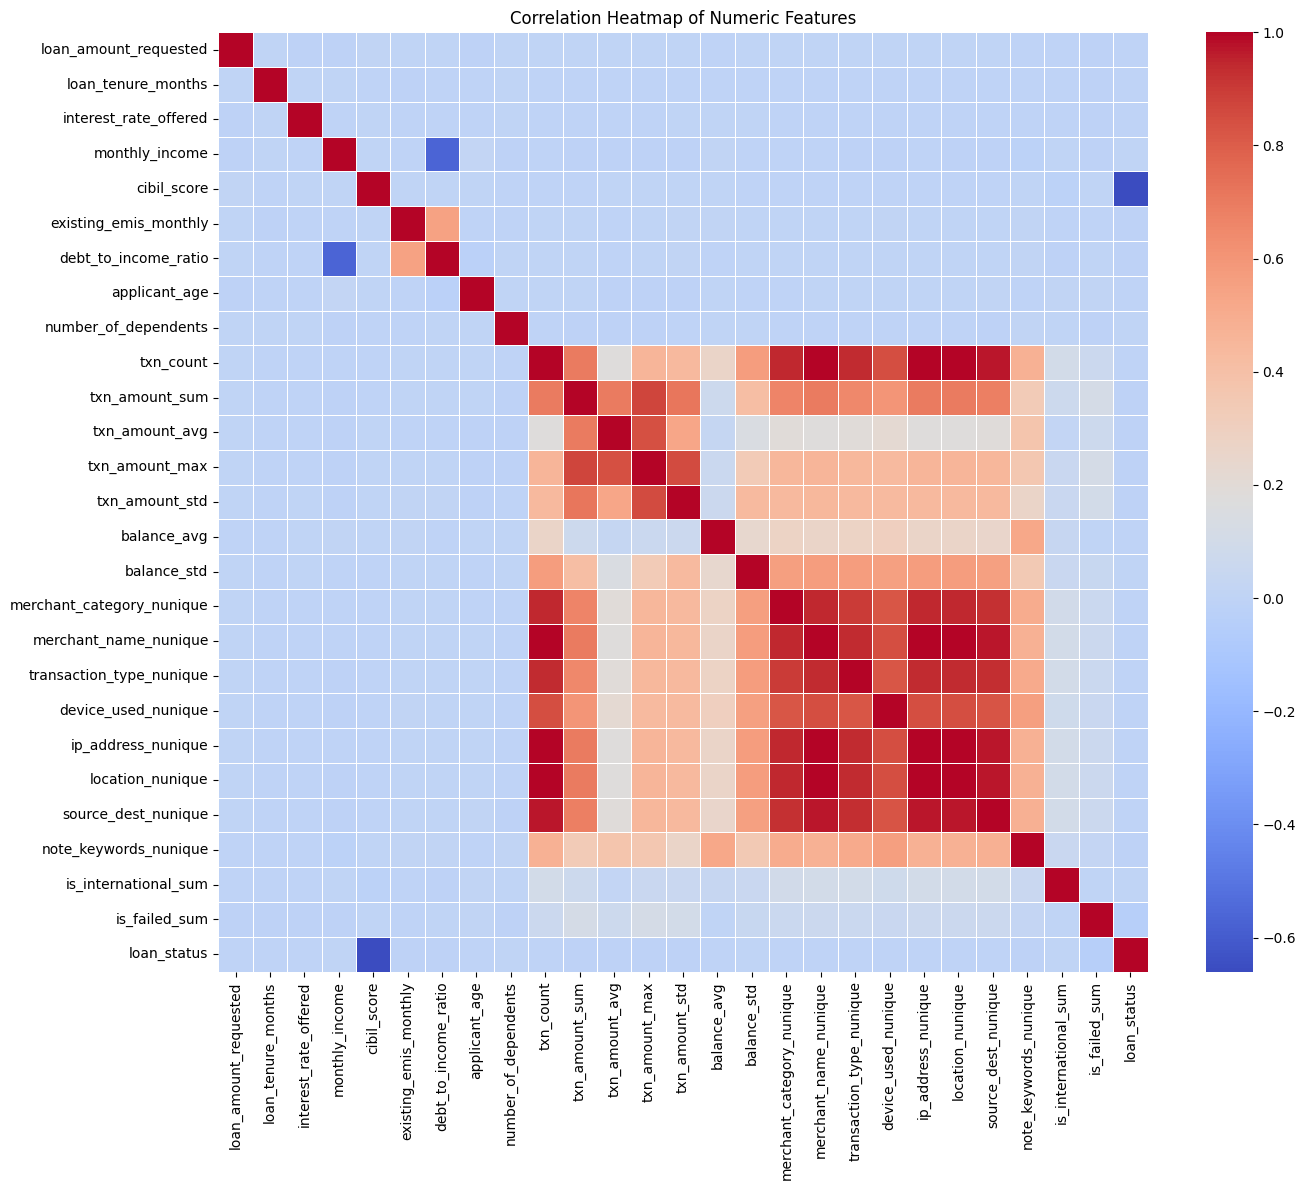

In [68]:
numeric_df = df_final.select_dtypes(include=['int64', 'float64']).copy()
numeric_df['loan_status'] = df_final['loan_status']

# 计算相关系数矩阵
corr_matrix = numeric_df.corr()

# 绘制热力图
plt.figure(figsize=(14, 12))
sns.heatmap(corr_matrix, annot=False, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title("Correlation Heatmap of Numeric Features")
plt.tight_layout()
plt.show()

In [69]:
# 需要删除的冗余列（2 datasets）
redundant_cols = [
    'txn_amount_avg',
    'txn_amount_max',
    'txn_amount_std',
    'balance_std',
    'merchant_category_nunique',
    'merchant_name_nunique',
    'device_used_nunique',
    'location_nunique',
    'transaction_type_nunique',
    'source_dest_nunique',
    'note_keywords_nunique',
    'residential_address',
    'gender',
    'cibil_score',
    'monthly_income',
    'customer_id',
    'application_date',
    'fraud_type'
]

# 创建新 DataFrame，去除这些冗余列
df_reduced = df_final.drop(columns=redundant_cols)

# 查看新数据集维度
df_reduced.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 19 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   loan_type                  50000 non-null  object 
 1   loan_amount_requested      50000 non-null  float64
 2   loan_tenure_months         50000 non-null  int64  
 3   interest_rate_offered      50000 non-null  float64
 4   purpose_of_loan            50000 non-null  object 
 5   employment_status          50000 non-null  object 
 6   existing_emis_monthly      50000 non-null  float64
 7   debt_to_income_ratio       50000 non-null  float64
 8   property_ownership_status  50000 non-null  object 
 9   applicant_age              50000 non-null  int64  
 10  number_of_dependents       50000 non-null  int64  
 11  loan_status                50000 non-null  bool   
 12  fraud_flag                 50000 non-null  bool   
 13  txn_count                  50000 non-null  flo

In [70]:
numerical = [col for col in df_reduced.columns if df_reduced[col].dtype in ['int64', 'float64']]
print('There are {} numerical variables\n'.format(len(numerical)))
print('They are:\n\n', numerical)

There are 13 numerical variables

They are:

 ['loan_amount_requested', 'loan_tenure_months', 'interest_rate_offered', 'existing_emis_monthly', 'debt_to_income_ratio', 'applicant_age', 'number_of_dependents', 'txn_count', 'txn_amount_sum', 'balance_avg', 'ip_address_nunique', 'is_international_sum', 'is_failed_sum']


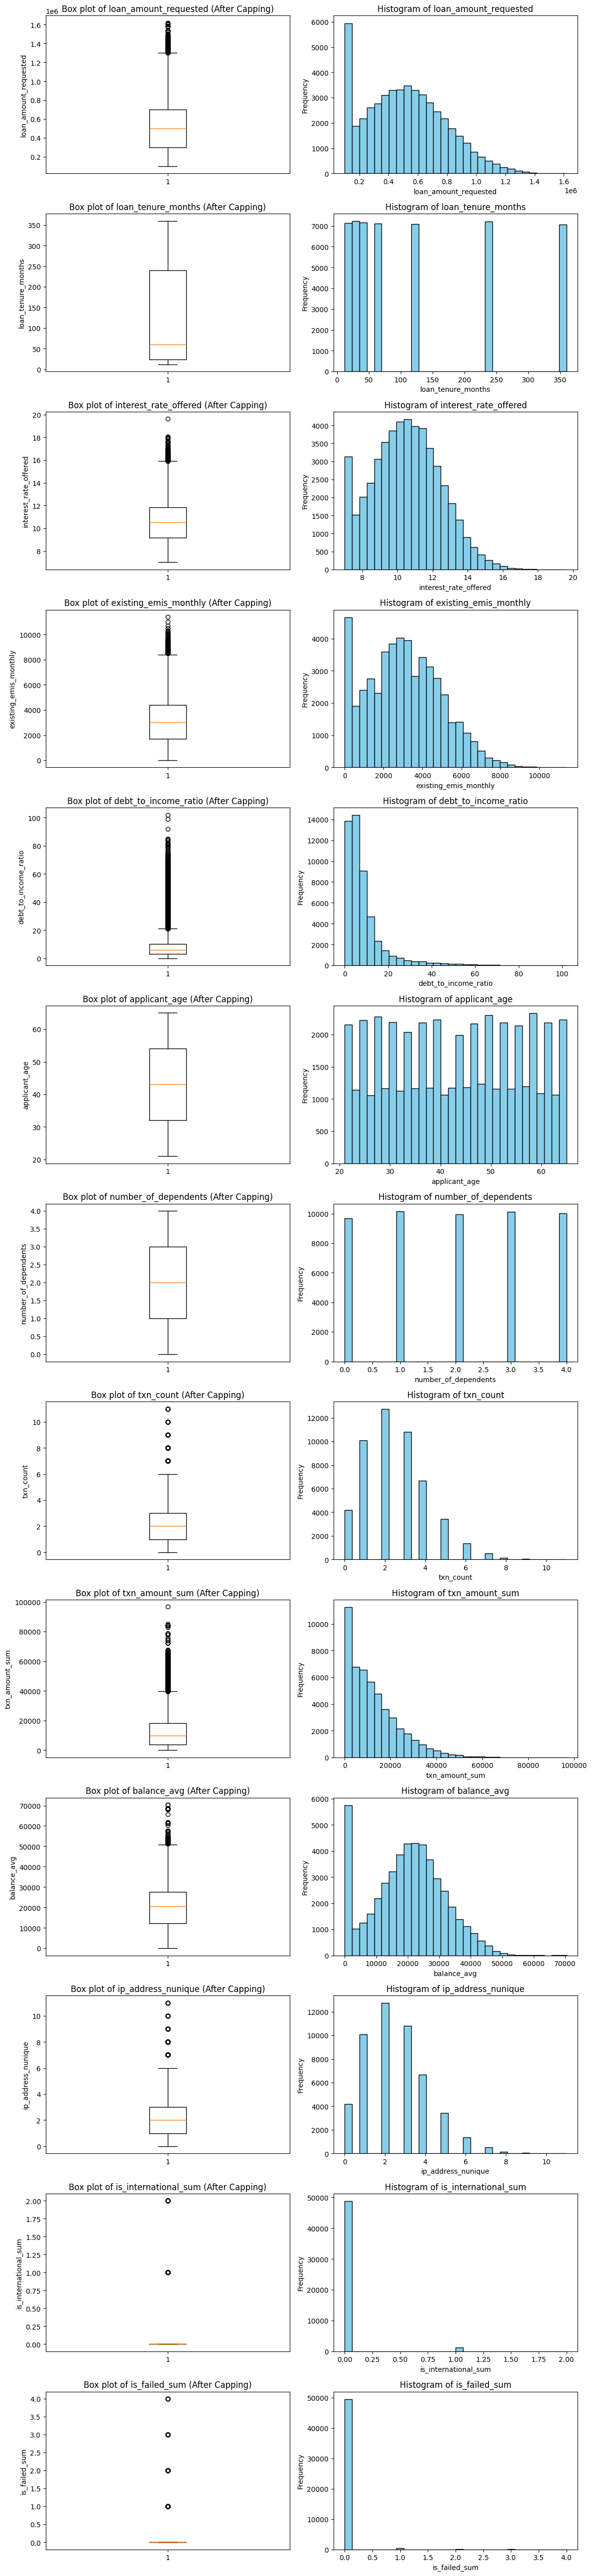

In [71]:

#每行两个图：左箱线图 + 右柱状图（直方图）
fig, axes = plt.subplots(nrows=len(numerical), ncols=2, figsize=(12, 4 * len(numerical)))

for i, col in enumerate(numerical):
    # 左图：箱线图
    axes[i, 0].boxplot(df_final[col].dropna(), vert=True)
    axes[i, 0].set_title(f'Box plot of {col} (After Capping)')
    axes[i, 0].set_ylabel(col)
    
    # 右图：直方图（柱状图）
    axes[i, 1].hist(df_final[col].dropna(), bins=30, color='skyblue', edgecolor='black')
    axes[i, 1].set_title(f'Histogram of {col}')
    axes[i, 1].set_xlabel(col)
    axes[i, 1].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

In [72]:
categorical = [var for var in df_reduced.columns if df_reduced[var].dtype=='O']

print('There are {} categorical variables\n'.format(len(categorical)))

print('They are :\n\n', categorical)

There are 4 categorical variables

They are :

 ['loan_type', 'purpose_of_loan', 'employment_status', 'property_ownership_status']


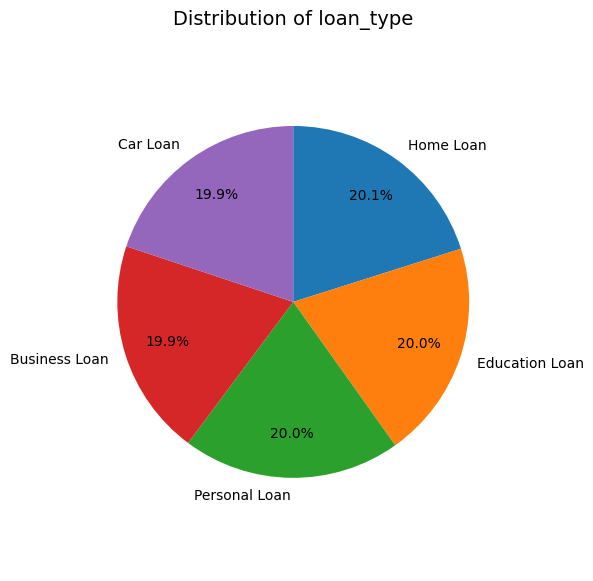

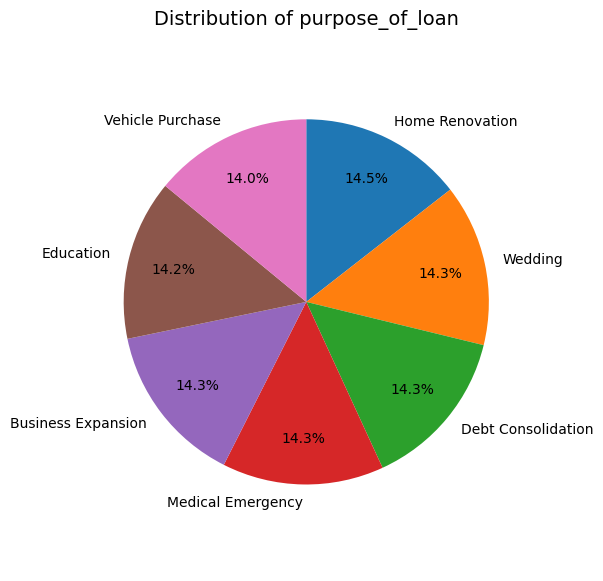

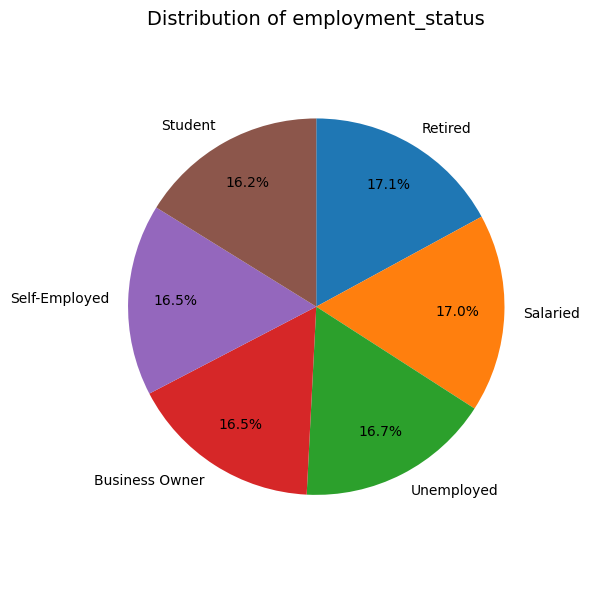

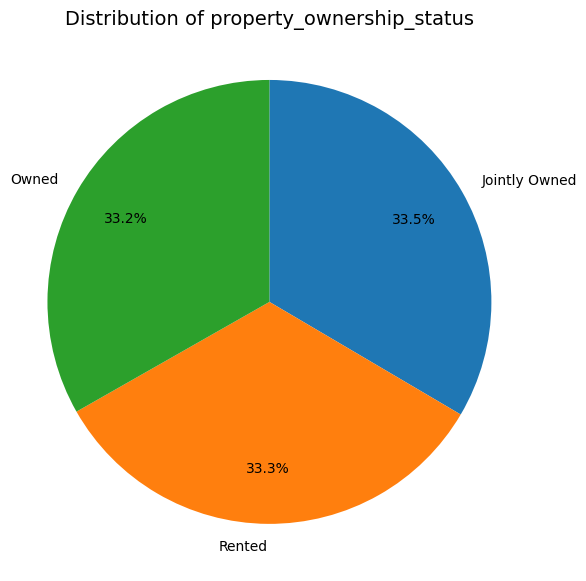

In [73]:

# 遍历每个分类变量，绘制饼图
for col in categorical:
    counts = df_final[col].value_counts(dropna=False)
    labels = counts.index.astype(str)
    values = counts.values

 # 设置图像和字体
    plt.figure(figsize=(6, 6))
    wedges, texts, autotexts = plt.pie(
            values,
            labels=labels,
            autopct='%1.1f%%',
            startangle=90,
            counterclock=False,
            textprops={'fontsize': 10},
            labeldistance=1.1,        # 控制标签与圆心距离（>1 放到外部）
            pctdistance=0.75          # 百分比的位置（稍微靠近中心）
        )

        # 设置标题
    plt.title(f'Distribution of {col}', fontsize=14)
    plt.axis('equal')  # 保证是圆形
    plt.tight_layout()
    plt.show()    
   

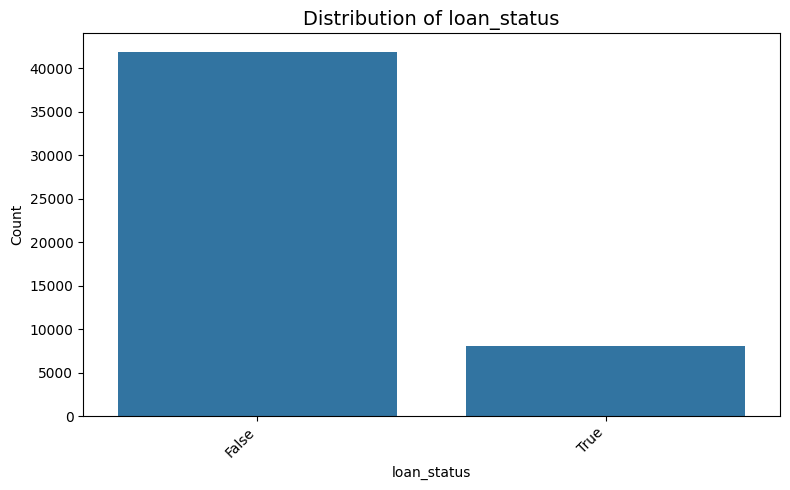

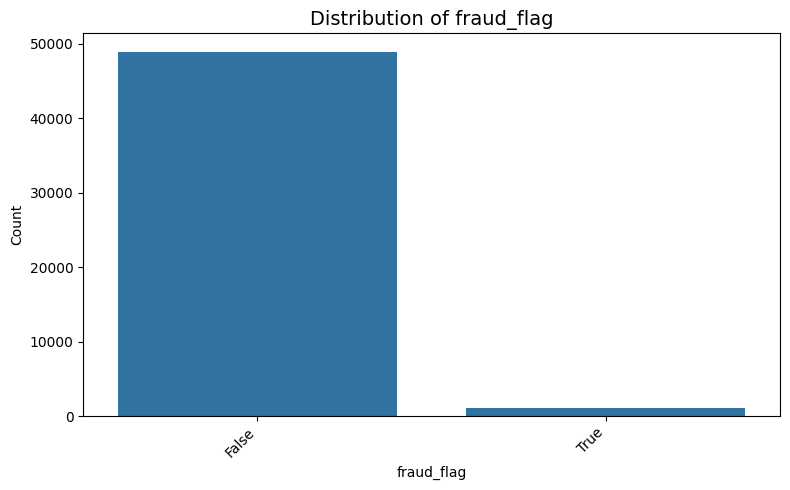

In [74]:
bool_val= ['loan_status','fraud_flag']

for col in bool_val:
    plt.figure(figsize=(8, 5))
    sns.countplot(data=df_final, x=col, order=df_final[col].value_counts().index)
    plt.title(f'Distribution of {col}', fontsize=14)
    plt.xlabel(col)
    plt.ylabel("Count")
    plt.xticks(rotation=45, ha='right')  # 旋转标签以防重叠
    plt.tight_layout()
    plt.show()

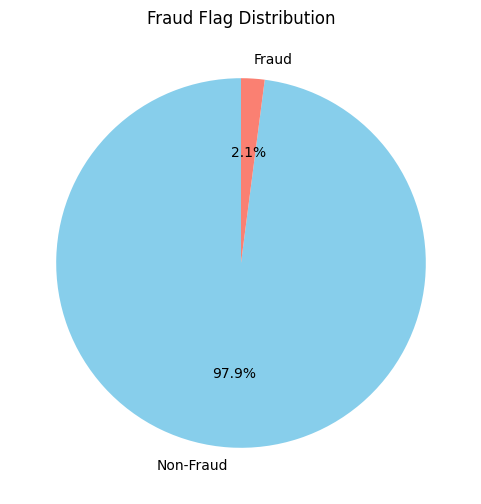

In [75]:
# Fraud比例饼图

plt.figure(figsize=(6, 6))
df_reduced['fraud_flag'].value_counts().plot.pie(autopct='%1.1f%%', labels=['Non-Fraud', 'Fraud'], startangle=90, colors=['skyblue', 'salmon'])
plt.title("Fraud Flag Distribution")
plt.ylabel("")
plt.show()

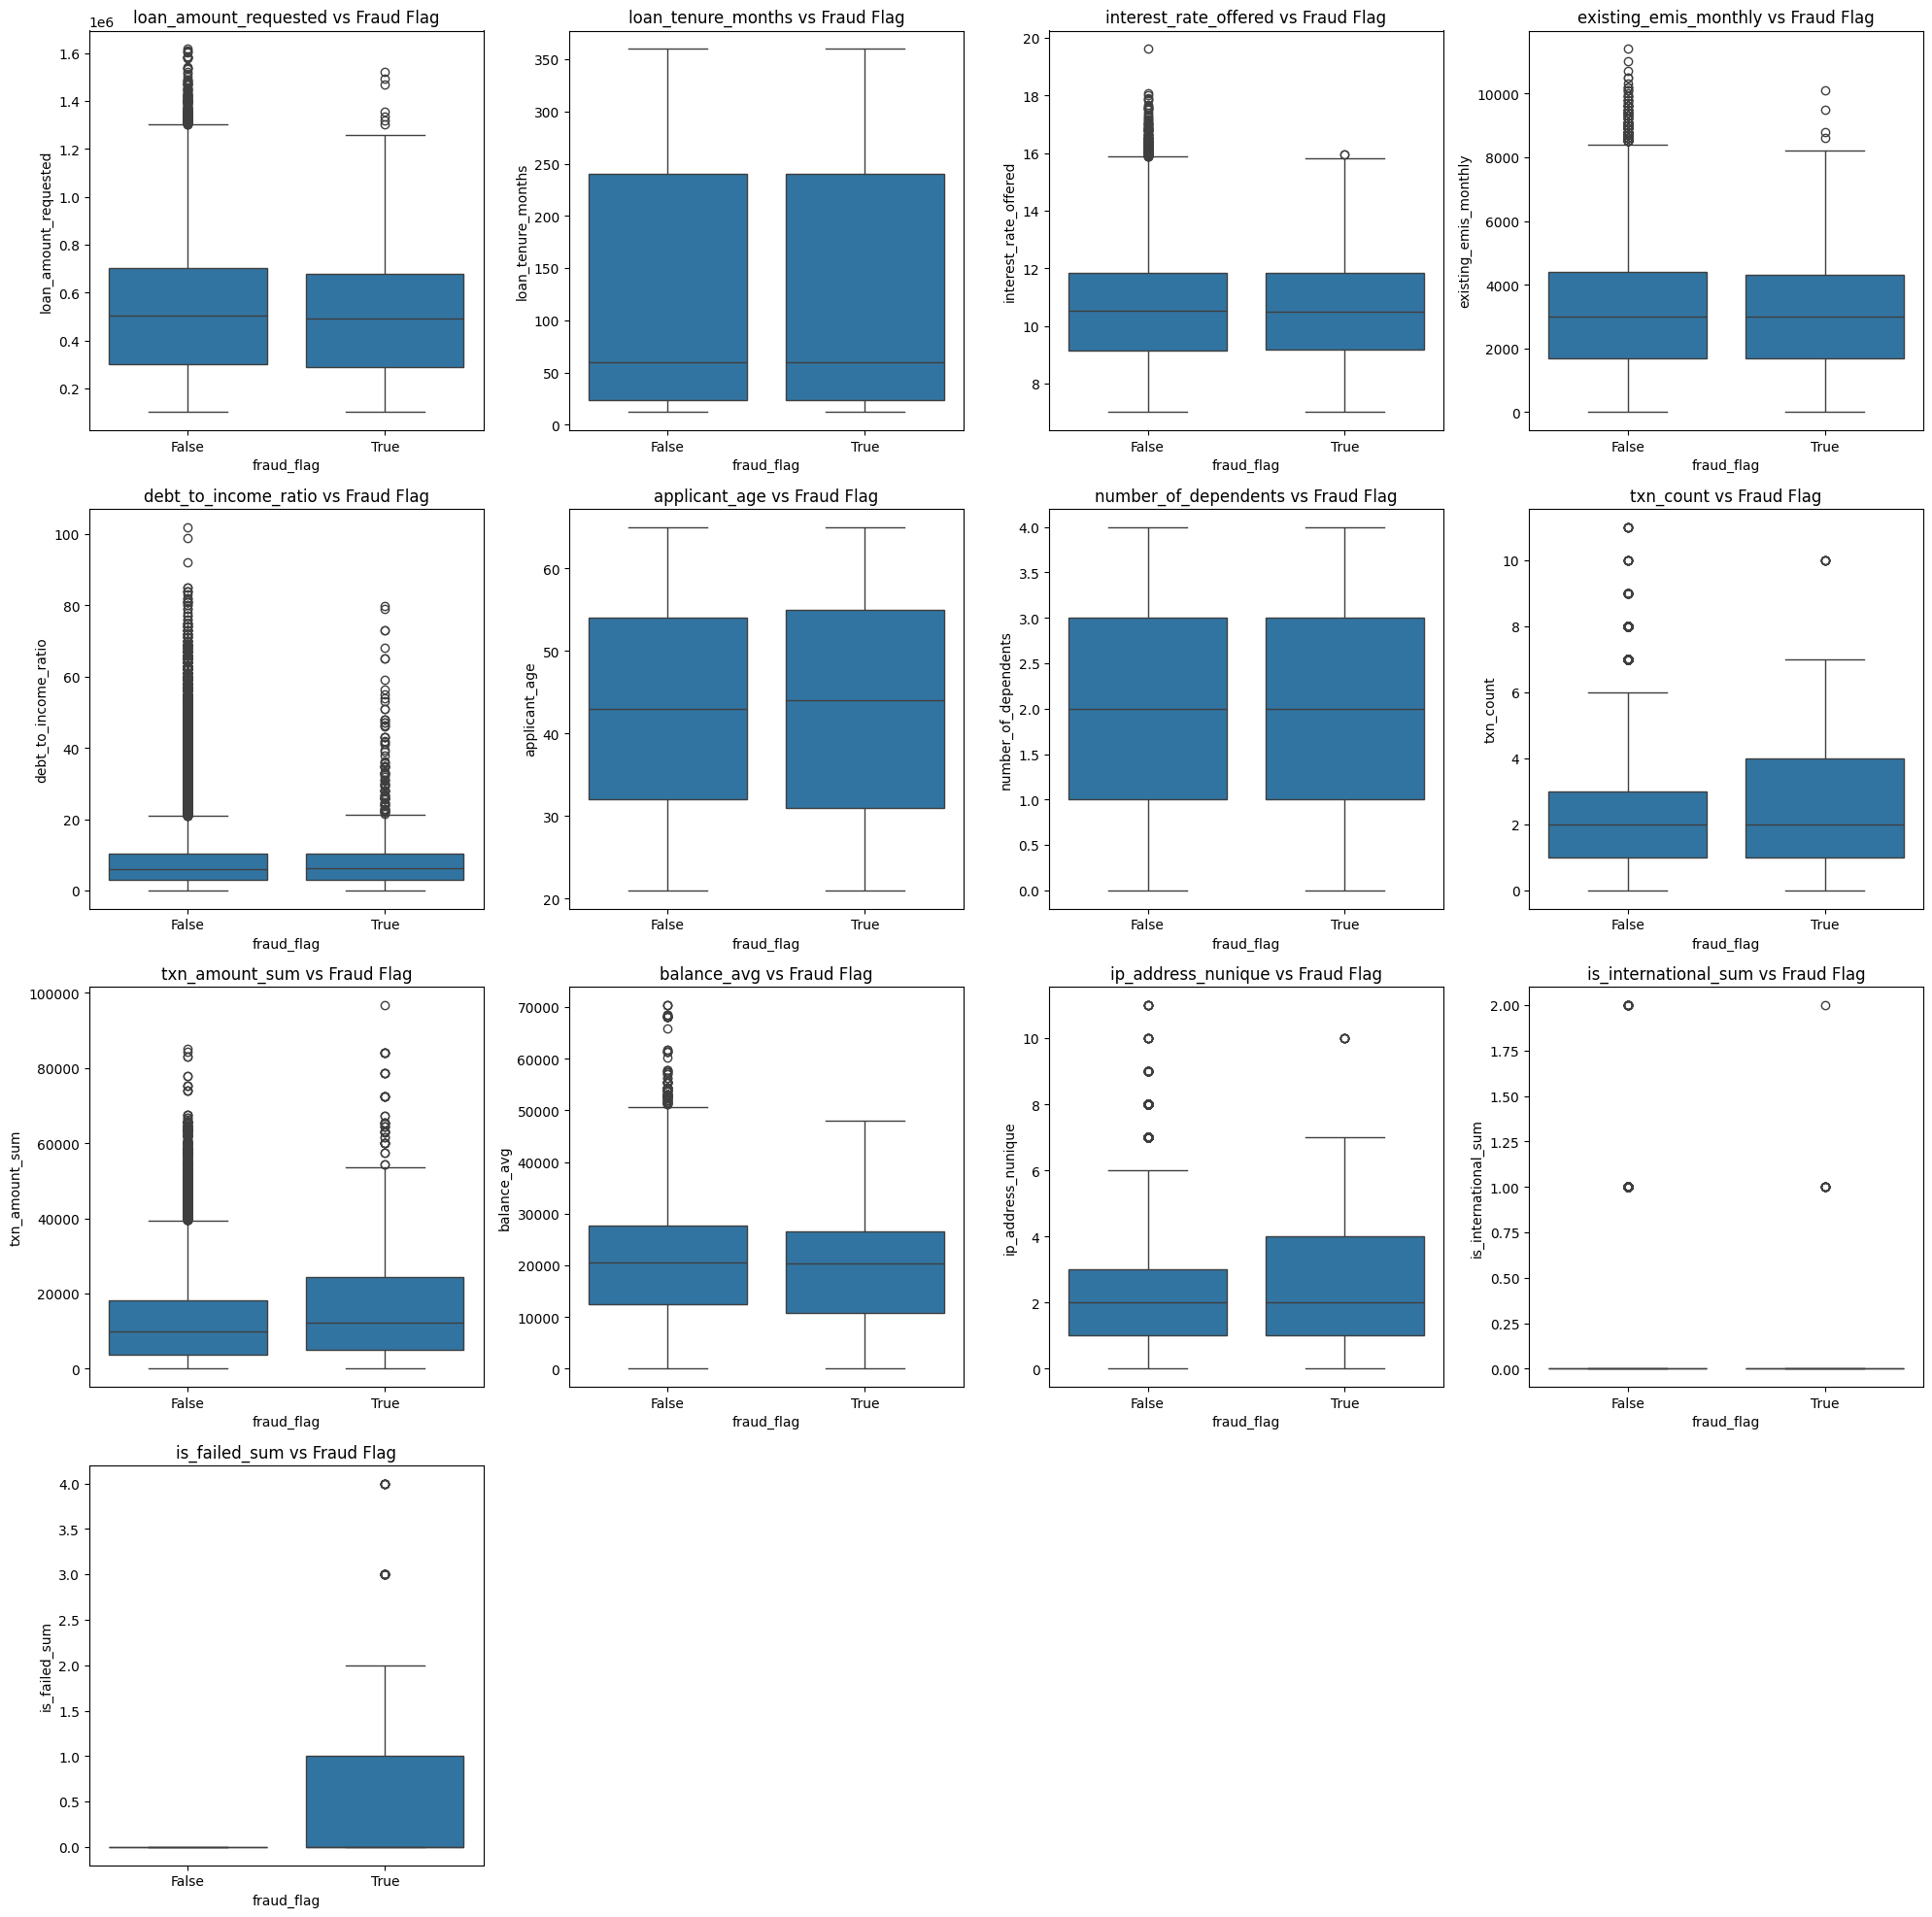

In [76]:
# 每行展示4张图
cols = 4
rows = math.ceil(len(numerical) / cols)

fig, axes = plt.subplots(rows, cols, figsize=(5 * cols, 5 * rows))
axes = axes.flatten()  # 将子图数组拉平以便索引

for i, col in enumerate(numerical):
    sns.boxplot(x='fraud_flag', y=col, data=df_reduced, ax=axes[i])
    axes[i].set_title(f"{col} vs Fraud Flag")

# 删除空白子图
for j in range(len(numerical), len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

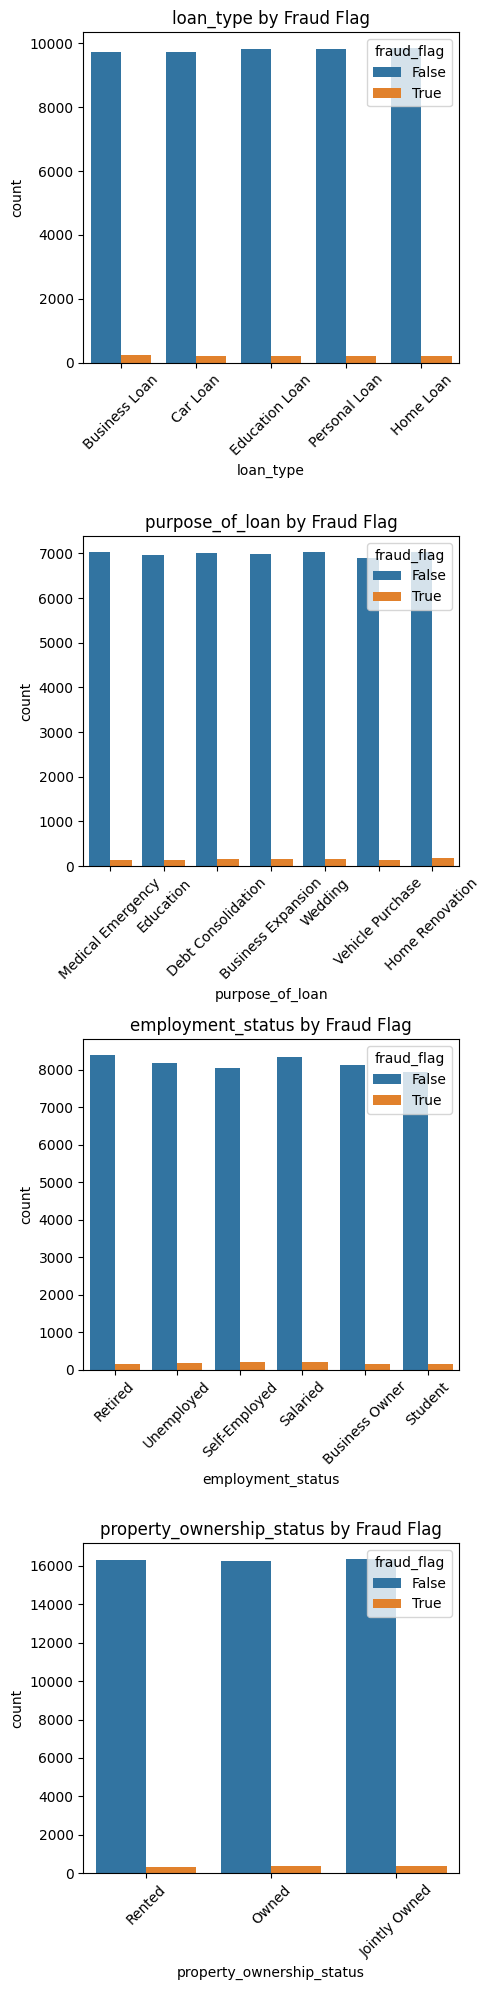

In [77]:
# Fraud vs 分类变量（分组柱状图）

fig, axes = plt.subplots(len(categorical), 1, figsize=(5, 5 * len(categorical)))
for i, col in enumerate(categorical):
    sns.countplot(x=col, hue='fraud_flag', data=df_reduced, ax=axes[i])
    axes[i].set_title(f"{col} by Fraud Flag")
    axes[i].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

In [78]:
#One-Hot 编码类别特征
df_encoded = pd.get_dummies(df_reduced, columns=categorical, drop_first=True)
df_encoded

,loan_amount_requested,loan_tenure_months,interest_rate_offered,existing_emis_monthly,debt_to_income_ratio,applicant_age,number_of_dependents,loan_status,fraud_flag,txn_count,...,purpose_of_loan_Medical Emergency,purpose_of_loan_Vehicle Purchase,purpose_of_loan_Wedding,employment_status_Retired,employment_status_Salaried,employment_status_Self-Employed,employment_status_Student,employment_status_Unemployed,property_ownership_status_Owned,property_ownership_status_Rented
0,604000.0,12,11.66,1100.0,3.17,28,3,False,False,2.0,...,True,False,False,True,False,False,False,False,False,True
1,100000.0,240,13.62,0.0,0.00,44,3,False,False,4.0,...,False,False,False,False,False,False,False,True,True,False
2,431000.0,60,11.40,4600.0,31.08,56,4,False,False,4.0,...,True,False,False,False,False,True,False,False,False,True
3,324000.0,120,10.36,4000.0,13.89,27,4,True,False,2.0,...,False,False,False,False,False,True,False,False,False,True
4,100000.0,36,14.14,1100.0,2.51,50,0,True,False,3.0,...,False,False,False,False,True,False,False,False,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49995,381000.0,24,12.05,2400.0,4.88,55,3,False,False,1.0,...,False,True,False,False,False,False,True,False,False,True
49996,736000.0,120,11.03,4000.0,13.99,61,0,False,False,1.0,...,True,False,False,False,False,False,True,False,False,False
49997,436000.0,12,10.98,600.0,1.43,48,4,False,False,3.0,...,False,False,True,False,False,False,True,False,False,False
49998,827000.0,24,16.18,8100.0,17.34,62,3,False,False,0.0,...,False,True,False,False,False,False,False,False,False,True


In [79]:
df_encoded.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 32 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   loan_amount_requested               50000 non-null  float64
 1   loan_tenure_months                  50000 non-null  int64  
 2   interest_rate_offered               50000 non-null  float64
 3   existing_emis_monthly               50000 non-null  float64
 4   debt_to_income_ratio                50000 non-null  float64
 5   applicant_age                       50000 non-null  int64  
 6   number_of_dependents                50000 non-null  int64  
 7   loan_status                         50000 non-null  bool   
 8   fraud_flag                          50000 non-null  bool   
 9   txn_count                           50000 non-null  float64
 10  txn_amount_sum                      50000 non-null  float64
 11  balance_avg                         50000

In [80]:
# 找出布尔列
bool_cols = df_encoded.select_dtypes(include=['bool']).columns

# 将布尔列转换为 0/1
df_encoded[bool_cols] = df_encoded[bool_cols].astype(int)
df_encoded

,loan_amount_requested,loan_tenure_months,interest_rate_offered,existing_emis_monthly,debt_to_income_ratio,applicant_age,number_of_dependents,loan_status,fraud_flag,txn_count,...,purpose_of_loan_Medical Emergency,purpose_of_loan_Vehicle Purchase,purpose_of_loan_Wedding,employment_status_Retired,employment_status_Salaried,employment_status_Self-Employed,employment_status_Student,employment_status_Unemployed,property_ownership_status_Owned,property_ownership_status_Rented
0,604000.0,12,11.66,1100.0,3.17,28,3,0,0,2.0,...,1,0,0,1,0,0,0,0,0,1
1,100000.0,240,13.62,0.0,0.00,44,3,0,0,4.0,...,0,0,0,0,0,0,0,1,1,0
2,431000.0,60,11.40,4600.0,31.08,56,4,0,0,4.0,...,1,0,0,0,0,1,0,0,0,1
3,324000.0,120,10.36,4000.0,13.89,27,4,1,0,2.0,...,0,0,0,0,0,1,0,0,0,1
4,100000.0,36,14.14,1100.0,2.51,50,0,1,0,3.0,...,0,0,0,0,1,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49995,381000.0,24,12.05,2400.0,4.88,55,3,0,0,1.0,...,0,1,0,0,0,0,1,0,0,1
49996,736000.0,120,11.03,4000.0,13.99,61,0,0,0,1.0,...,1,0,0,0,0,0,1,0,0,0
49997,436000.0,12,10.98,600.0,1.43,48,4,0,0,3.0,...,0,0,1,0,0,0,1,0,0,0
49998,827000.0,24,16.18,8100.0,17.34,62,3,0,0,0.0,...,0,1,0,0,0,0,0,0,0,1


In [81]:
df_encoded.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 32 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   loan_amount_requested               50000 non-null  float64
 1   loan_tenure_months                  50000 non-null  int64  
 2   interest_rate_offered               50000 non-null  float64
 3   existing_emis_monthly               50000 non-null  float64
 4   debt_to_income_ratio                50000 non-null  float64
 5   applicant_age                       50000 non-null  int64  
 6   number_of_dependents                50000 non-null  int64  
 7   loan_status                         50000 non-null  int64  
 8   fraud_flag                          50000 non-null  int64  
 9   txn_count                           50000 non-null  float64
 10  txn_amount_sum                      50000 non-null  float64
 11  balance_avg                         50000

In [82]:
X = df_encoded.drop('fraud_flag', axis=1)
y = df_encoded['fraud_flag']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

In [83]:
# 自动识别非 0/1 的连续数值列
all_numeric_cols = X_train.select_dtypes(include=['int64', 'float64']).columns
binary_cols = [col for col in all_numeric_cols if X_train[col].dropna().isin([0, 1]).all()]
numeric_cols = [col for col in all_numeric_cols if col not in binary_cols]

scaler = StandardScaler()
X_train[numeric_cols] = scaler.fit_transform(X_train[numeric_cols])
X_test[numeric_cols] = scaler.transform(X_test[numeric_cols])

In [84]:
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)
print("SMOTE 后类别分布：\n", y_train_resampled.value_counts())

SMOTE 后类别分布：
 fraud_flag
0    39179
1    39179
Name: count, dtype: int64


In [85]:
log_reg = LogisticRegression(max_iter=1000, class_weight='balanced', random_state=42)
log_reg.fit(X_train_resampled, y_train_resampled)
y_pred_log = log_reg.predict(X_test)
y_prob_log = log_reg.predict_proba(X_test)[:, 1]

print("=== Logistic Regression ===")
print("AUC:", roc_auc_score(y_test, y_prob_log))
print(classification_report(y_test, y_pred_log))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_log))

=== Logistic Regression ===
AUC: 0.8094717314707605
              precision    recall  f1-score   support

           0       0.99      0.93      0.96      9795
           1       0.14      0.54      0.22       205

    accuracy                           0.92     10000
   macro avg       0.56      0.74      0.59     10000
weighted avg       0.97      0.92      0.94     10000

Confusion Matrix:
 [[9107  688]
 [  94  111]]


In [86]:
from sklearn.model_selection import RandomizedSearchCV
# 参数搜索范围
rf_param_grid = {
    'n_estimators': [100, 200, 300, 500],
    'max_depth': [None, 5, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2']
}

# 定义模型
rf = RandomForestClassifier(random_state=42)

# 使用 RandomizedSearchCV
rf_random_search = RandomizedSearchCV(
    rf,
    param_distributions=rf_param_grid,
    n_iter=20,             # 随机搜索 20 组参数
    scoring='roc_auc',     # 以 AUC 作为优化目标
    cv=3,                  # 3 折交叉验证
    verbose=2,
    random_state=42,
    n_jobs=-1
)

# 训练
rf_random_search.fit(X_train_resampled, y_train_resampled)
print("RF 最佳参数：", rf_random_search.best_params_)
print("RF 最佳 AUC：", rf_random_search.best_score_)

Fitting 3 folds for each of 20 candidates, totalling 60 fits
[CV] END max_depth=20, max_features=log2, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   8.6s
[CV] END max_depth=20, max_features=log2, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   8.7s
[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=200; total time=  14.4s
[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=200; total time=  14.5s
[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=200; total time=  14.6s
[CV] END max_depth=20, max_features=log2, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   8.7s
[CV] END max_depth=None, max_features=log2, min_samples_leaf=1, min_samples_split=10, n_estimators=200; total time=  19.2s
[CV] END max_depth=None, max_features=log2, min_samples_leaf=1, min_samples_split=10, n_estimato

In [87]:
# 使用调参后的最佳参数
rf = RandomForestClassifier(
    n_estimators=300,
    max_depth=None,
    min_samples_split=5,
    min_samples_leaf=1,
    max_features='log2',
    random_state=42
)

# 训练模型
rf.fit(X_train_resampled, y_train_resampled)

# 预测
y_pred_rf = rf.predict(X_test)
y_prob_rf = rf.predict_proba(X_test)[:, 1]

# 输出结果
print("=== Random Forest (最佳参数) ===")
print("AUC:", roc_auc_score(y_test, y_prob_rf))
print(classification_report(y_test, y_pred_rf))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_rf))

=== Random Forest (最佳参数) ===
AUC: 0.8642134488726203
              precision    recall  f1-score   support

           0       0.99      1.00      0.99      9795
           1       0.82      0.50      0.62       205

    accuracy                           0.99     10000
   macro avg       0.90      0.75      0.81     10000
weighted avg       0.99      0.99      0.99     10000

Confusion Matrix:
 [[9772   23]
 [ 102  103]]


In [88]:
# 1. 定义基础 XGBoost 模型
xgb = XGBClassifier(
    random_state=42,
    eval_metric='logloss'  # 防止报 warning
)

# 2. 定义超参数搜索范围
xgb_param_grid = {
    'n_estimators': [100, 200, 300, 500],        # 树的数量
    'max_depth': [3, 5, 7, 10],                  # 最大树深度
    'learning_rate': [0.01, 0.05, 0.1, 0.2],     # 学习率
    'subsample': [0.6, 0.8, 1.0],                # 采样比例
    'colsample_bytree': [0.6, 0.8, 1.0],         # 特征采样比例
    'min_child_weight': [1, 3, 5],               # 子节点最小权重
    'gamma': [0, 0.1, 0.3, 0.5]                  # 分裂所需最小损失减少
}

# 3. 使用 RandomizedSearchCV 进行搜索
xgb_random_search = RandomizedSearchCV(
    estimator=xgb,
    param_distributions=xgb_param_grid,
    n_iter=20,               # 随机搜索 20 组参数
    scoring='roc_auc',       # 优化目标：AUC
    cv=3,                    # 3 折交叉验证
    verbose=2,
    random_state=42,
    n_jobs=-1                # 使用所有CPU核心
)

# 4. 执行超参数搜索
xgb_random_search.fit(X_train_resampled, y_train_resampled)

# 5. 输出最佳参数和得分
print("XGBoost 最佳参数：", xgb_random_search.best_params_)
print("XGBoost 最佳 AUC：", xgb_random_search.best_score_)

Fitting 3 folds for each of 20 candidates, totalling 60 fits
[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.05, max_depth=5, min_child_weight=5, n_estimators=100, subsample=1.0; total time=   0.7s
[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.05, max_depth=5, min_child_weight=5, n_estimators=100, subsample=1.0; total time=   0.7s
[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.05, max_depth=5, min_child_weight=5, n_estimators=100, subsample=1.0; total time=   0.7s
[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.01, max_depth=5, min_child_weight=1, n_estimators=300, subsample=0.6; total time=   1.7s
[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.01, max_depth=5, min_child_weight=1, n_estimators=300, subsample=0.6; total time=   1.8s
[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=300, subsample=0.8; total time=   1.3s
[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0

In [89]:
xgb = XGBClassifier(
    n_estimators=500,
    max_depth=10,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=1,
    random_state=42,
    lr =  0.2,
    gamma =  0.1
)

xgb.fit(X_train_resampled, y_train_resampled)
y_pred_xgb = xgb.predict(X_test)
y_prob_xgb = xgb.predict_proba(X_test)[:, 1]

print("=== XGBoost  ===")
print("AUC:", roc_auc_score(y_test, y_prob_xgb))
print(classification_report(y_test, y_pred_xgb))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_xgb))

=== XGBoost  ===
AUC: 0.9423892229733937
              precision    recall  f1-score   support

           0       0.99      1.00      0.99      9795
           1       0.98      0.51      0.67       205

    accuracy                           0.99     10000
   macro avg       0.99      0.75      0.83     10000
weighted avg       0.99      0.99      0.99     10000

Confusion Matrix:
 [[9793    2]
 [ 101  104]]


In [90]:
metrics = {
    'Model': ['Logistic Regression', 'Random Forest', 'XGBoost'],
    'Accuracy': [
        accuracy_score(y_test, y_pred_log),
        accuracy_score(y_test, y_pred_rf),
        accuracy_score(y_test, y_pred_xgb)
    ],
    'Precision': [
        precision_score(y_test, y_pred_log),
        precision_score(y_test, y_pred_rf),
        precision_score(y_test, y_pred_xgb)
    ],
    'Recall': [
        recall_score(y_test, y_pred_log),
        recall_score(y_test, y_pred_rf),
        recall_score(y_test, y_pred_xgb)
    ],
    'F1 Score': [
        f1_score(y_test, y_pred_log),
        f1_score(y_test, y_pred_rf),
        f1_score(y_test, y_pred_xgb)
    ],
    'AUC': [
        roc_auc_score(y_test, y_prob_log),
        roc_auc_score(y_test, y_prob_rf),
        roc_auc_score(y_test, y_prob_xgb)
    ]
}

results_df = pd.DataFrame(metrics)
print(results_df)

                 Model  Accuracy  Precision    Recall  F1 Score       AUC
0  Logistic Regression    0.9218   0.138924  0.541463  0.221116  0.809472
1        Random Forest    0.9875   0.817460  0.502439  0.622356  0.864213
2              XGBoost    0.9897   0.981132  0.507317  0.668810  0.942389


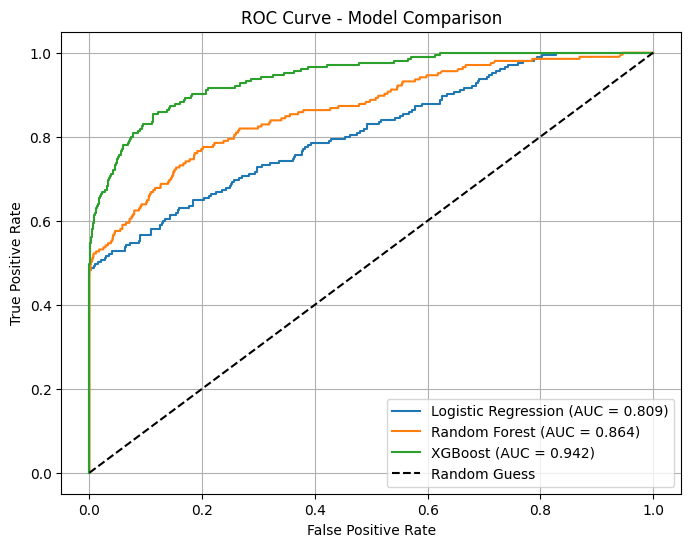

In [91]:
# 计算 FPR、TPR 和 AUC
fpr_log, tpr_log, _ = roc_curve(y_test, y_prob_log)
auc_log = roc_auc_score(y_test, y_prob_log)

fpr_rf, tpr_rf, _ = roc_curve(y_test, y_prob_rf)
auc_rf = roc_auc_score(y_test, y_prob_rf)

fpr_xgb, tpr_xgb, _ = roc_curve(y_test, y_prob_xgb)
auc_xgb = roc_auc_score(y_test, y_prob_xgb)

# 绘制 ROC 曲线
plt.figure(figsize=(8, 6))
plt.plot(fpr_log, tpr_log, label=f"Logistic Regression (AUC = {auc_log:.3f})")
plt.plot(fpr_rf, tpr_rf, label=f"Random Forest (AUC = {auc_rf:.3f})")
plt.plot(fpr_xgb, tpr_xgb, label=f"XGBoost (AUC = {auc_xgb:.3f})")
plt.plot([0, 1], [0, 1], 'k--', label="Random Guess")

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Model Comparison")
plt.legend(loc="lower right")
plt.grid()
plt.show()